# Dogs vs Cats: Deep Learning with Transfer Learning & Fine-Tuning


## 1. Introduction
This notebook shows how to apply deep learning to a binary image classification problem (cats vs dogs), using both a custom CNN and transfer learning (fine-tuning VGG16). We will explore the dataset, compare the approaches, and draw insights into their successes and failures.

## 2. Data Preparation

In [27]:
import os, shutil, pathlib

# Paths - only run this block if you need to create the 5,000 image subset
original_dir = pathlib.Path("./data/kaggle_dogs_vs_cats/train")  # Full dataset dir (25,000 images)
new_base_dir = pathlib.Path("./data/kaggle_dogs_vs_cats_small")  # Desired small set

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = original_dir / fname
            dst = dir / fname
            if not os.path.exists(dst):
                shutil.copyfile(src, dst)

# 1,000 train per class, 500 valid per class, 1,000 test per class
make_subset("train", 0, 1000)
make_subset("validation", 1000, 1500)
make_subset("test", 1500, 2500)


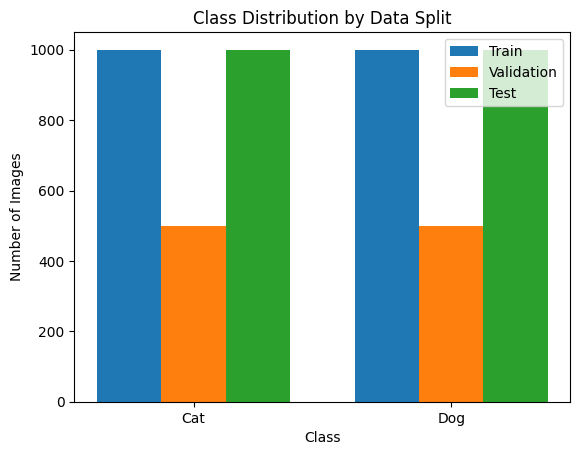

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# If your class counts differ, update the below numbers accordingly.
splits = ['Train', 'Validation', 'Test']
counts = [[1000, 1000], [500, 500], [1000, 1000]]  # [cats, dogs] per split (edit if needed)
classes = ['Cat', 'Dog']

width = 0.25
x = np.arange(len(classes))
fig, ax = plt.subplots()
for idx, (split, count) in enumerate(zip(splits, counts)):
    ax.bar(x + idx * width, count, width=width, label=split)
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution by Data Split')
ax.legend()
plt.show()


## 3. Exploratory Data Analysis (EDA)

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import collections
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

data_folder = pathlib.Path('./data/kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32,
    shuffle=True
)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32
)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### 3.1 Dataset Overview

Class names: ['cat', 'dog']
Training batches: 63
Validation batches: 32
Test batches: 63


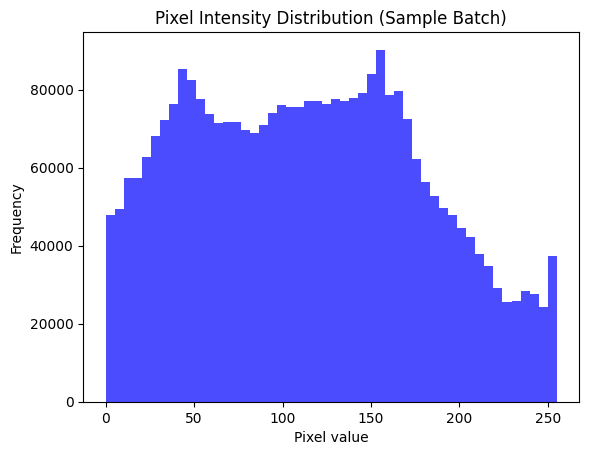

In [30]:
class_names = train_dataset.class_names
print("Class names:", class_names)
print("Training batches:", train_dataset.cardinality().numpy())
print("Validation batches:", validation_dataset.cardinality().numpy())
print("Test batches:", test_dataset.cardinality().numpy())

for batch in train_dataset.take(1):
    images, _ = batch
    plt.hist(images.numpy().flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Intensity Distribution (Sample Batch)')
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    plt.show()



### 3.2 Visualizing Images

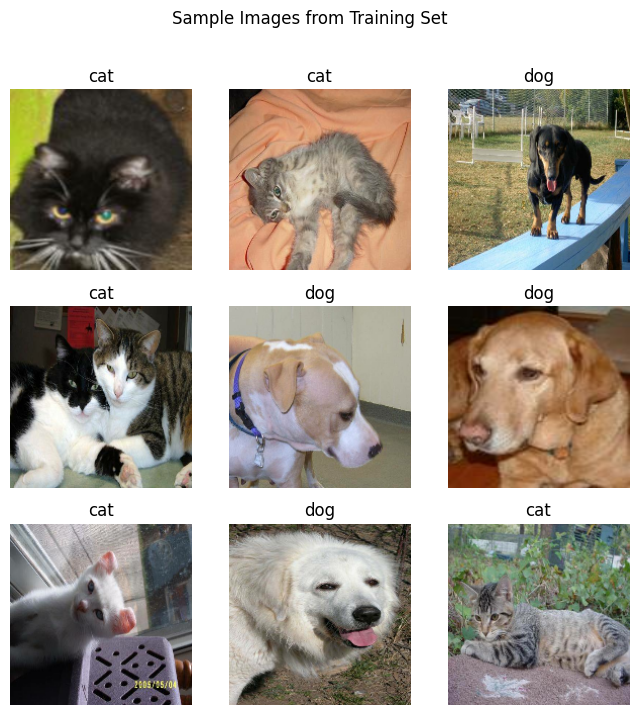

In [31]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Training Set")
plt.show()


### 3.3 Class Balance

In [32]:
counter = collections.Counter()
for _, labels in train_dataset:
    counter.update(labels.numpy())
print({class_names[i]: count for i, count in counter.items()})


{'dog': 1000, 'cat': 1000}


## 4. Model 1 – Custom Convolutional Neural Network (CNN)


### 4.1 Model Design


In [33]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
cnn_model = keras.Model(inputs, outputs)
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
cnn_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     3,276,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,177 (12.86 MB)

 Trainable params: 3,370,177 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Training


In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/cnn_best_model.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history_cnn = cnn_model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 331ms/step - accuracy: 0.5250 - loss: 0.7240 - val_accuracy: 0.6040 - val_loss: 0.6881
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - accuracy: 0.6130 - loss: 0.6503 - val_accuracy: 0.6060 - val_loss: 0.6420
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 354ms/step - accuracy: 0.6660 - loss: 0.6129 - val_accuracy: 0.6380 - val_loss: 0.6500
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - accuracy: 0.7025 - loss: 0.5660 - val_accuracy: 0.6830 - val_loss: 0.6159
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.7405 - loss: 0.5131 - val_accuracy: 0.6810 - val_loss: 0.6229
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.7845 - loss: 0.4561 - val_accuracy: 0.6950 - val_loss: 0.6248
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.8260 - loss: 0.3695 - val_accuracy: 0.7010 - val_loss: 0.6641
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.8850 - loss: 0.2687 - val_accu

### 4.3 Learning Curves


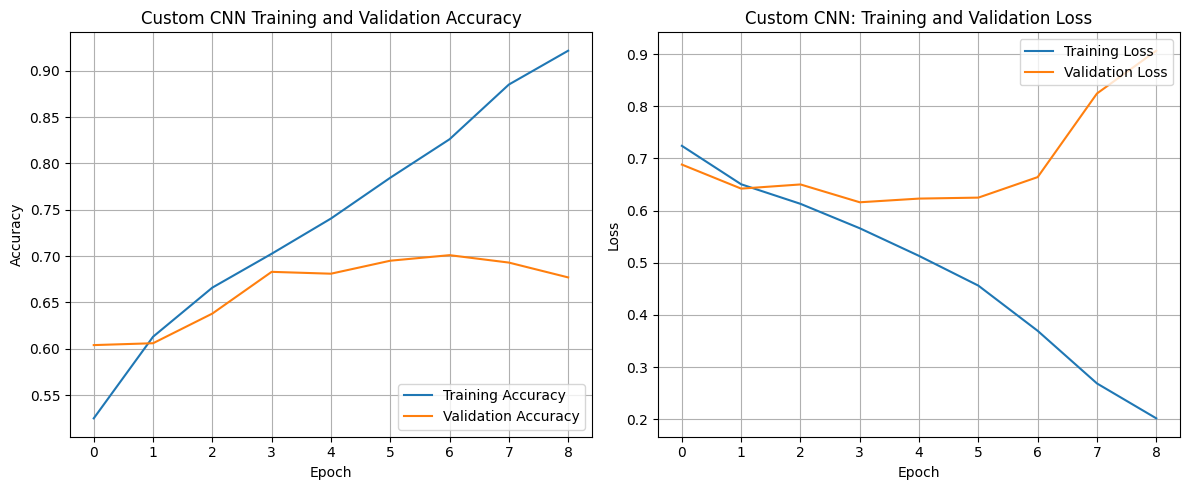

In [35]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Custom CNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Custom CNN: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


## 5. Model 2 – Transfer Learning (VGG16 Fine-Tuning)


### 5.1  Using VGG16 as the Base


In [36]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))
conv_base.trainable = False  # Freeze for initial training


### 5.2 Model Construction


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 180, 180,  │          0 │ input_layer_10[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 180, 180,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 180, 180,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │  3,277,056 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        257 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

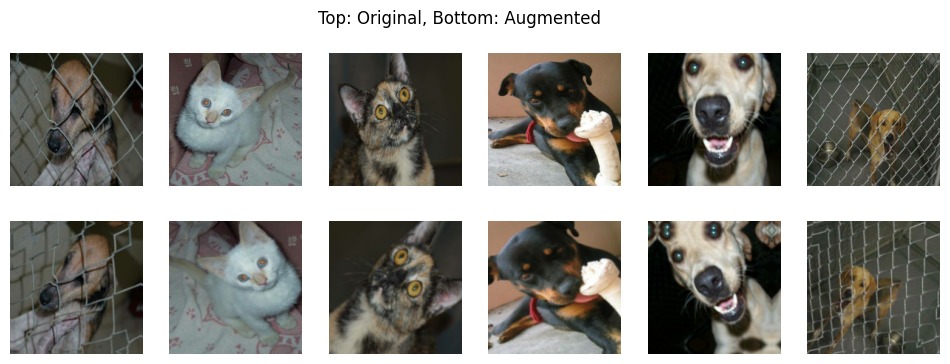

In [37]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vgg_model = keras.Model(inputs, outputs)
vgg_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
vgg_model.summary()

for batch in train_dataset.take(1):
    images, _ = batch
    augmented_images = data_augmentation(images)
    plt.figure(figsize=(12,4))
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.subplot(2, 6, i+7)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis('off')
    plt.suptitle('Top: Original, Bottom: Augmented')
    plt.show()
    break


### 5.3 Training


In [38]:
callbacks_ft = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/vgg16_finetune_best.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history_vgg = vgg_model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks_ft
)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.8880 - loss: 3.1023 - val_accuracy: 0.9720 - val_loss: 0.4552
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - accuracy: 0.9480 - loss: 0.7716 - val_accuracy: 0.9680 - val_loss: 0.3002
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - accuracy: 0.9520 - loss: 0.3394 - val_accuracy: 0.9750 - val_loss: 0.1473
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.9620 - loss: 0.2011 - val_accuracy: 0.9780 - val_loss: 0.0942
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - accuracy: 0.9610 - loss: 0.1329 - val_accuracy: 0.9790 - val_loss: 0.0731
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.9690 - loss: 0.1017 - val_accuracy: 0.9720 - val_loss: 0.1009
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.9715 - loss: 0.0863 - val_accuracy: 0.9770 - val_loss: 0.1105
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.9690 - loss: 0.1152 - val_accuracy: 0.9760 - v

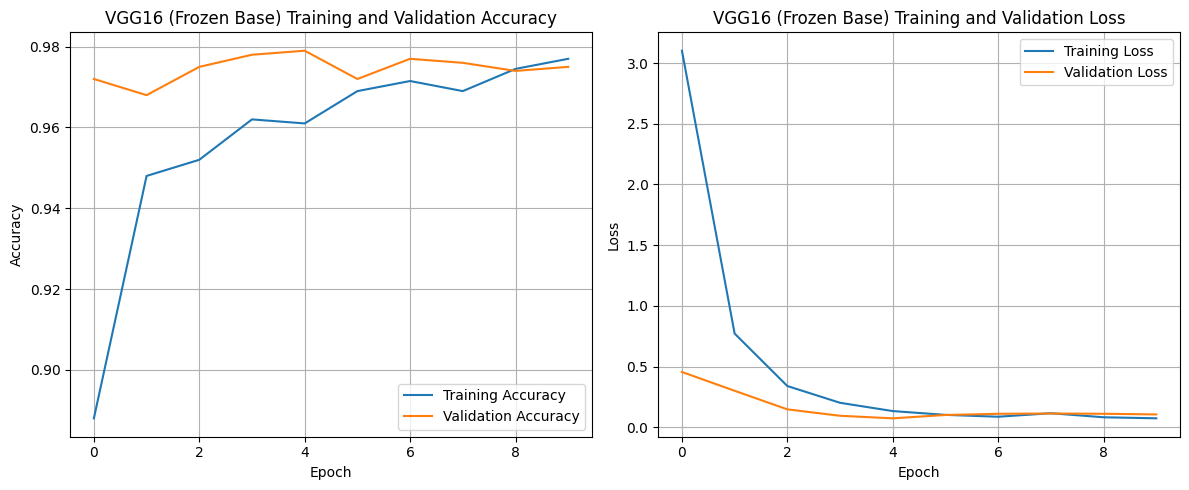

In [39]:
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('VGG16 (Frozen Base) Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('VGG16 (Frozen Base) Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


5.4 Fine-Tuning Higher Layers


In [40]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

vgg_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(1e-5), metrics=["accuracy"])

# Continue training for a few epochs to fine-tune
history_fine = vgg_model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks_ft
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.9700 - loss: 0.1022 - val_accuracy: 0.9810 - val_loss: 0.0767
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9770 - loss: 0.0572 - val_accuracy: 0.9800 - val_loss: 0.0787
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.9810 - loss: 0.0617 - val_accuracy: 0.9810 - val_loss: 0.0787
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9840 - loss: 0.0469 - val_accuracy: 0.9830 - val_loss: 0.0783
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.9860 - loss: 0.0419 - val_accuracy: 0.9790 - val_loss: 0.0926


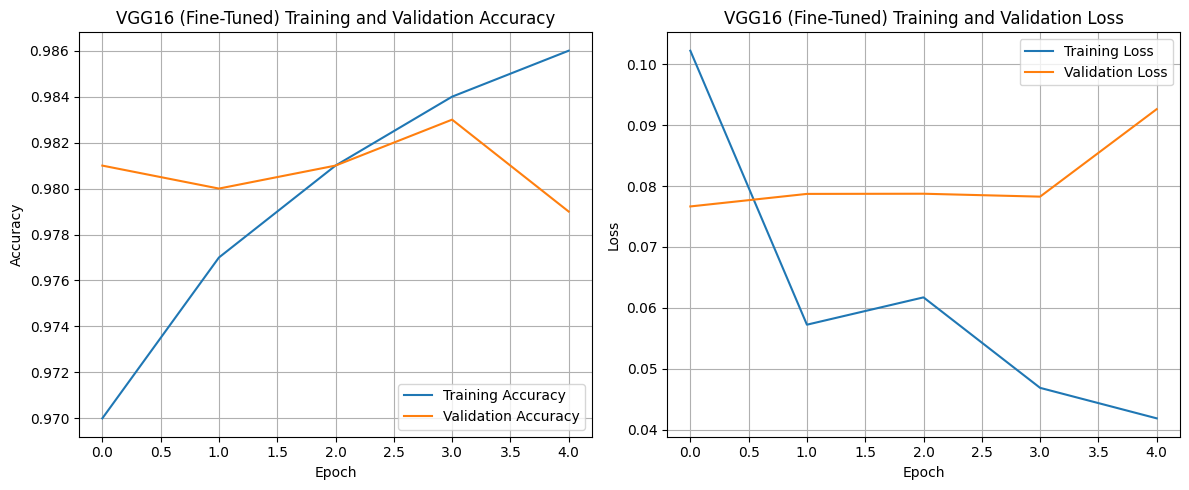

In [41]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('VGG16 (Fine-Tuned) Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('VGG16 (Fine-Tuned) Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


## 6. Model Evaluation & Comparison


### 6.1 Reloading Best Models


In [42]:
best_cnn = keras.models.load_model("models/cnn_best_model.keras")
best_vgg = keras.models.load_model("models/vgg16_finetune_best.keras")


### 6.2 Accuracy Scores


In [43]:
cnn_loss, cnn_acc = best_cnn.evaluate(test_dataset)
vgg_loss, vgg_acc = best_vgg.evaluate(test_dataset)
print(f"Custom CNN Test Accuracy: {cnn_acc:.3f}")
print(f"VGG16 Fine-Tuned Test Accuracy: {vgg_acc:.3f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6740 - loss: 0.6155
63/63 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9750 - loss: 0.0951
Custom CNN Test Accuracy: 0.674
VGG16 Fine-Tuned Test Accuracy: 0.975


### 6.3 Confusion Matrix and Metrics


In [44]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve

# Collect predictions and true labels
y_true = []
y_cnn_pred = []
y_vgg_pred = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    y_cnn_pred.extend(best_cnn.predict(images).flatten())
    y_vgg_pred.extend(best_vgg.predict(images).flatten())
y_true = np.array(y_true)
y_cnn_bin = np.array(y_cnn_pred) > 0.5
y_vgg_bin = np.array(y_vgg_pred) > 0.5

cm_cnn = confusion_matrix(y_true, y_cnn_bin)
cm_vgg = confusion_matrix(y_true, y_vgg_bin)
print("CNN Confusion Matrix:\n", cm_cnn)
print("VGG Confusion Matrix:\n", cm_vgg)

print(f'Custom CNN - Precision: {precision_score(y_true, y_cnn_bin):.2f}, Recall: {recall_score(y_true, y_cnn_bin):.2f}, F1: {f1_score(y_true, y_cnn_bin):.2f}')
print(f'VGG16 Fine-Tuned - Precision: {precision_score(y_true, y_vgg_bin):.2f}, Recall: {recall_score(y_true, y_vgg_bin):.2f}, F1: {f1_score(y_true, y_vgg_bin):.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### 6.4 Precision-Recall Curve


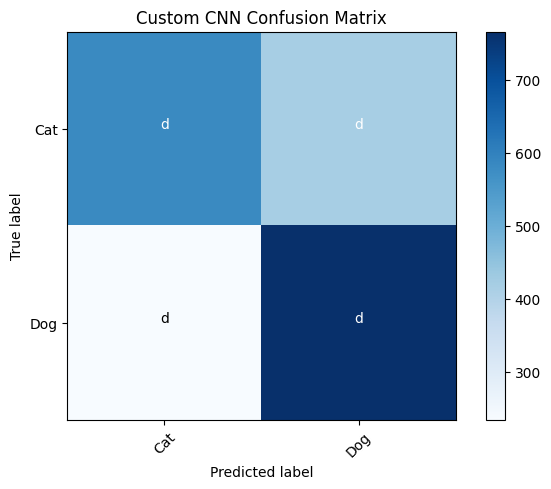

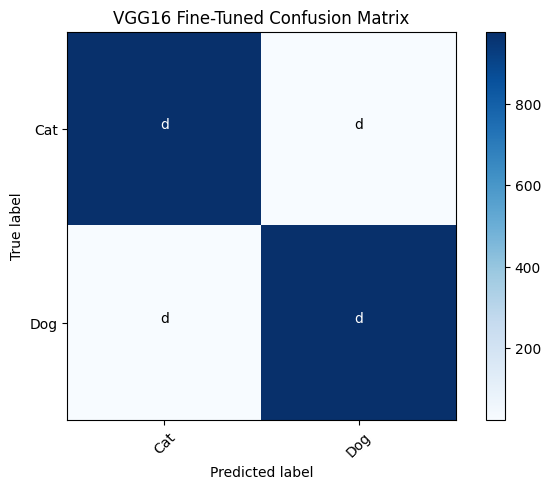

In [45]:
import itertools



plt.imshow(cm_cnn, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Custom CNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm_cnn.max() / 2.
for i, j in itertools.product(range(cm_cnn.shape[0]), range(cm_cnn.shape[1])):
    plt.text(j, i, fmt.format(cm_cnn[i, j]),
                horizontalalignment="center",
                color="white" if cm_cnn[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


plt.imshow(cm_vgg, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('VGG16 Fine-Tuned Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm_vgg.max() / 2.
for i, j in itertools.product(range(cm_vgg.shape[0]), range(cm_vgg.shape[1])):
    plt.text(j, i, fmt.format(cm_vgg[i, j]),
                horizontalalignment="center",
                color="white" if cm_vgg[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### 6.5 Failure Analysis


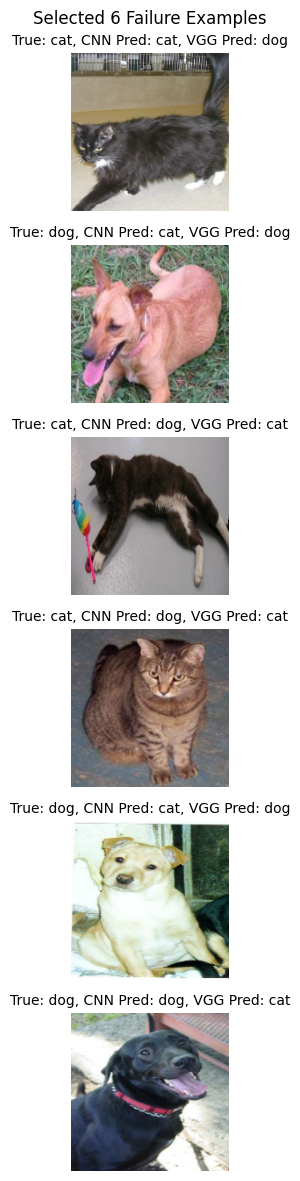

In [46]:
import random
failure_idxs = np.where((y_true != y_cnn_bin) | (y_true != y_vgg_bin))[0]
num_failure_examples_to_show = 6 # You can adjust this number
if len(failure_idxs) > 0:
    plt.figure(figsize=(10, num_failure_examples_to_show * 2)) # Adjust figure size dynamically
    examples_shown = 0
    # Shuffle failure_idxs to get random examples if there are many
    random.shuffle(failure_idxs)
    for ix in failure_idxs:
        if examples_shown >= num_failure_examples_to_show:
            break

        # Find the image in the test_dataset (this might be slow for large datasets)
        # A more efficient way would be to create a list of all test images and labels once
        # or iterate through the test_dataset more carefully.
        # For simplicity here, we'll re-iterate for the specific index.
        current_idx_in_batch = ix
        for batch_images, batch_labels in test_dataset:
            if current_idx_in_batch < len(batch_labels):
                img = batch_images[current_idx_in_batch].numpy().astype("uint8")
                true_label = class_names[batch_labels[current_idx_in_batch]]
                cnn_pred_label = class_names[int(y_cnn_bin[ix])]
                vgg_pred_label = class_names[int(y_vgg_bin[ix])]

                plt.subplot(num_failure_examples_to_show, 1, examples_shown + 1)
                plt.imshow(img)
                plt.title(
                    f"True: {true_label}, CNN Pred: {cnn_pred_label}, VGG Pred: {vgg_pred_label}",
                    fontsize=10
                )
                plt.axis("off")
                examples_shown += 1
                break
            current_idx_in_batch -= len(batch_labels)
    plt.suptitle(f"Selected {examples_shown} Failure Examples")
    plt.tight_layout()
    plt.show()


## 7. Discussion and Conclusions
### Summary Points:

In this project, two deep learning approaches were applied to the binary image classification problem of distinguishing between cats and dogs: a custom Convolutional Neural Network (CNN) and a VGG16 model fine-tuned using transfer learning. The discussion highlights that a comparison between these models is crucial, focusing on which one exhibited superior performance and the underlying reasons for their respective outcomes.

A key aspect to elaborate on is the impact of transfer learning; specifically, how fine-tuning the VGG16 model either accelerated the training process or led to improved performance when compared to the custom CNN. The analysis should also address whether either model displayed clear indications of overfitting or underfitting, and how strategies such as callbacks or data augmentation were employed to mitigate these issues. Furthermore, it's important to identify common failure cases, describing the specific types of images or categories that both the custom CNN and the transfer learning model struggled to classify accurately.

To conclude, the summary should propose actionable next steps or strategies that could be implemented to further enhance the models' performance. A significant takeaway from this project is that transfer learning generally yields substantial improvements, even when working with relatively small datasets. Ultimately, the optimal model choice depends on various factors, including the size of the dataset, the computational resources available, and the specific requirement for maximum accuracy.